# Siamese Networks for One-Shot Learning

The purpose of these Siamese CNNs will be to predict which out of 5 given images corresponds to the same room as the one from a reference picture. The images belong to Airbnb rental rooms. There are between 2 to 5 images for each room (mean=2.8), so this is a case of one-shot or few-shot learning. Rooms can include kitchens, bedrooms, living rooms, bathrooms, and others.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Reshape, UpSampling2D, Activation
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.callbacks import EarlyStopping
from PIL import Image
from keras.utils import to_categorical
from keras import backend as K
from keras.regularizers import l2
from keras.losses import binary_crossentropy
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import cv2
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import seaborn as sns
import urllib
from pathlib import Path
from tqdm.notebook import tqdm
import pickle
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
def plot_loss(history):
  n_epochs = max(history.epoch)+1
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = range(1,n_epochs+1)
  fig, ax = plt.subplots(figsize=(18,6))
  ax = sns.lineplot(x=epochs, y=loss_train,  label='training loss')
  ax = sns.lineplot(x=epochs, y=loss_val,  label='validation loss')
  ax.grid(color='black', linestyle='-', linewidth=0.1)
  ax.set_xticks(np.arange(1,n_epochs,2))
  ax.set_xlim(1)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [3]:
def show_image(im):
  fig, ax = plt.subplots(figsize=(6,6))
  plt.imshow(im)
  plt.axis('off')
  plt.show()

# Load Airbnb Data

In [ ]:
def get_images(directory):
    Images = []
    Labels = [] 
    
    for labels in tqdm(os.listdir(directory)): #Main Directory where each class label is present as folder name.
        label1=labels
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
          city = image_file.split('_')[0]
          code = image_file.split('_')[1]
          label=label1+'_'+city+'_'+code
          image = cv2.imread(directory+labels+r'/'+image_file, 0) #Reading the image (OpenCV) 0 means greyscale
          image = cv2.resize(image,(256,256), interpolation = cv2.INTER_AREA) #Resize the image, Some images are different sizes. (Resizing is very Important)
          Images.append(image)
          Labels.append(label)
        
#     return Images, Labels
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.


In [ ]:
Images_train_grey, Labels_train_grey = get_images("/content/drive/MyDrive/data/one_shot_images/Airbnb Data/Training Data/")

In [ ]:
Images_test_grey, Labels_test_grey = get_images("/content/drive/MyDrive/data/one_shot_images/Airbnb Data/Test Data/")

In [ ]:
x_train = np.asarray(Images_train)
x_test = np.asarray(Images_test)

In [ ]:
x_train.shape

(631, 256, 256)

In [ ]:
y_train = pd.get_dummies(Labels_train_grey).values
y_test = pd.get_dummies(Labels_test_grey).values

### To save as pickles:

In [ ]:
with open(os.path.join("/content", "drive", "MyDrive", "data", "one_shot_images", "Airbnb Data", "x_train_grey.p"), "wb") as f:
    pickle.dump(x_train, f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "one_shot_images", "Airbnb Data", "Images_train_grey.p"), "wb") as f:
    pickle.dump(Images_train_grey, f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "one_shot_images", "Airbnb Data", "Labels_train_grey.p"), "wb") as f:
    pickle.dump(Labels_train_grey, f)

In [ ]:
with open(os.path.join("/content", "drive", "MyDrive", "data", "one_shot_images", "Airbnb Data", "x_test_grey.p"), "wb") as f:
    pickle.dump(x_test, f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "one_shot_images", "Airbnb Data", "Images_test_grey.p"), "wb") as f:
    pickle.dump(Images_test_grey, f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "one_shot_images", "Airbnb Data", "Labels_test_grey.p"), "wb") as f:
    pickle.dump(Labels_test_grey, f)

In [ ]:
with open(os.path.join("/content", "drive", "MyDrive", "data", "one_shot_images", "Airbnb Data", "y_train_grey.p"), "wb") as f:
    pickle.dump(y_train, f)

In [ ]:
with open(os.path.join("/content", "drive", "MyDrive", "data", "one_shot_images", "Airbnb Data", "y_test_grey.p"), "wb") as f:
    pickle.dump(y_test, f)

### To load the pickles:

In [4]:
# To read the pickles we can do this:
with open(os.path.join("/content", "drive", "MyDrive", "data", "one_shot_images", "Airbnb Data", "x_train.p"), "rb") as f:
    x_train = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "one_shot_images", "Airbnb Data", "x_test.p"), "rb") as f:
    x_test = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data",  "one_shot_images", "Airbnb Data", "y_train.p"), "rb") as f:
    y_train = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data",  "one_shot_images", "Airbnb Data", "y_test.p"), "rb") as f:
    y_test = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "one_shot_images", "Airbnb Data", "Images_train.p"), "rb") as f:
    Images_train = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data", "one_shot_images", "Airbnb Data", "Images_test.p"), "rb") as f:
    Images_test = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data",  "one_shot_images", "Airbnb Data", "Labels_train.p"), "rb") as f:
    Labels_train = pickle.load(f)
with open(os.path.join("/content", "drive", "MyDrive", "data",  "one_shot_images", "Airbnb Data", "Labels_test.p"), "rb") as f:
    Labels_test = pickle.load(f)

In [6]:
x_train = x_train.astype('float32')
x_train /= 255
x_test = x_test.astype('float32')
x_test /= 255

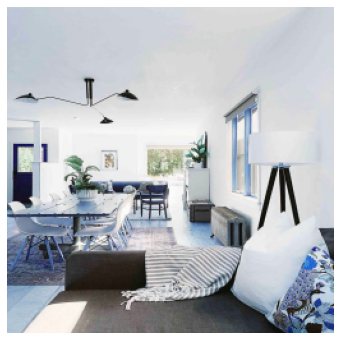

dining-room_seattle_5680462


In [7]:
show_image(Images_train[66])
print(Labels_train[66])

In [8]:
len(np.unique(Labels_train))

277

In [9]:
pd.Series(Labels_train).value_counts().mean()

2.2779783393501805

We have 277 different classes. On average we have 2.28 examples of each class, which makes this task a clear one-shot-learning task. Let's see how well we can do with a Siamese network.

In [10]:
x_train.shape

(631, 256, 256, 3)

# Siamese Network Architecture

In [11]:
input_shape = (256, 256, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)
# build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.35))
convnet.add(Conv2D(128, (7,7), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.35))
convnet.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.2))
convnet.add(Conv2D(128, (4,4), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.4))
convnet.add(Dense(2048, activation="sigmoid", kernel_regularizer=l2(1e-3)))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)

opt = keras.optimizers.Adam(learning_rate=0.00005) ## This low learning rate proved to provide more stability in training and less overfitting
siamese_net.compile(loss="mean_squared_error", optimizer=opt)
siamese_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 247, 247, 64)      19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 123, 123, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 123, 123, 64)      256       
_________________________________________________________________
dropout (Dropout)            (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 117, 128)     401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 58, 58, 128)       5

In [12]:
def get_batch(X, Y, labels, batch_size):
    """Create batch of n pairs, half same class, half different class"""
    categories = np.random.choice(labels, size=(batch_size,))
    pairs = [np.zeros((batch_size, 256, 256, 3)) for i in range(2)]
    examples = [np.zeros((batch_size, )) for i in range(2)]
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for z in range(int(batch_size)):
      category = categories[z]
      if z<batch_size/2:
        indices = [i for i, x in enumerate(labels) if x == category]
        m = np.random.choice(indices)
        n = np.random.choice(indices)
        timer=0
        while (m==n) & (timer<5):
          n= np.random.choice(indices)
          timer += 1
        if m==n:
          m = np.random.choice(indices)
          n = np.random.choice(indices)
        pairs[0][z, :, :, :] = X[m]
        pairs[1][z, :, :, :] = X[n]
        examples[0][z]=m
        examples[1][z]=n
      else:
        indices1 = [i for i, x in enumerate(labels) if x == category]
        indices2 = [i for i, x in enumerate(labels) if x != category]
        m = np.random.choice(indices1)
        n = np.random.choice(indices2)
        pairs[0][z, :, :, :] = X[m]
        pairs[1][z, :, :, :] = X[n]
        examples[0][z]=m
        examples[1][z]=n
    return pairs, targets, examples

def batch_generator(X, Y, labels, batch_size):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets, examples = get_batch(X, Y, labels, batch_size)
        yield (pairs, targets)

In [13]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15)
history = siamese_net.fit_generator(batch_generator(x_train, y_train, Labels_train, batch_size=20), 
                          validation_data=batch_generator(x_test, y_test, Labels_test, batch_size=20),
                          validation_steps=40,
                          steps_per_epoch=80, epochs=80,
                          callbacks=early_stopping_callback)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
80/80 [==============================] - 41s 394ms/step - loss: 4.1864 - val_loss: 3.9801
Epoch 2/80
80/80 [==============================] - 33s 412ms/step - loss: 3.7692 - val_loss: 3.6680
Epoch 3/80
80/80 [==============================] - 33s 411ms/step - loss: 3.4458 - val_loss: 3.4026
Epoch 4/80
80/80 [==============================] - 32s 406ms/step - loss: 3.1657 - val_loss: 3.1449
Epoch 5/80
80/80 [==============================] - 33s 409ms/step - loss: 2.9195 - val_loss: 2.8899
Epoch 6/80
80/80 [==============================] - 32s 405ms/step - loss: 2.6888 - val_loss: 2.6868
Epoch 7/80
80/80 [==============================] - 33s 409ms/step - loss: 2.4861 - val_loss: 2.4867
Epoch 8/80
80/80 [==============================] - 33s 409ms/step - loss: 2.2815 - val_loss: 2.2911
Epoch 9/80
80/80 [==============================] - 33s 408ms/step - loss: 2.1019 - val_loss: 2.1122
Epoch 10/80
80/80 [==============================] - 33s 408ms/step - loss: 1.9308 - val_lo

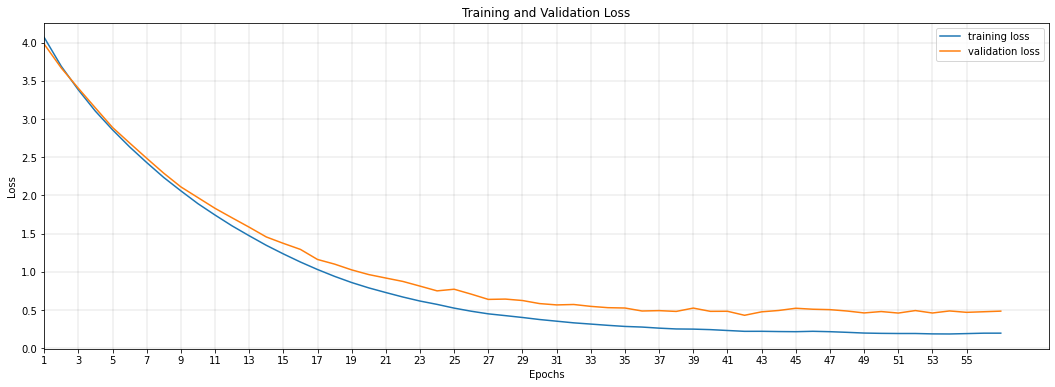

In [14]:
plot_loss(history)

First let's see how well we do on the training examples when predicting the probability of two input images belonging to the same room.

In [15]:
pairs, targets, examples = get_batch(x_train, y_train, Labels_train, batch_size=200)

In [16]:
preds = siamese_net.predict(pairs)
preds_ = [1 if x>0.5 else 0 for x in preds]

In [17]:
diff = abs(preds_-targets)
1 - diff.mean()

0.97

We get it right 97% of the time on the training set, suggesting overfitting perhaps.

Ground-Truth: DIFFERENT CLASS
Prediction: DIFFERENT CLASS
Similarity:  1.68 %


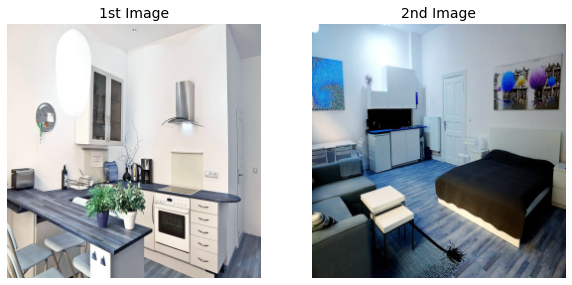

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
i = np.random.randint(1,len(preds))
plt.subplot(1,2,1)
plt.imshow(x_test[int(examples[0][i])])
plt.axis('off')
plt.title('1st Image', fontsize=14)
plt.subplot(1,2,2)
plt.imshow(x_test[int(examples[1][i])])
plt.axis('off')
plt.title('2nd Image', fontsize=14)
if int(targets[i])==0:
  print("Ground-Truth: SAME CLASS")
else:
  print("Ground-Truth: DIFFERENT CLASS")
if int(preds_[i])==0:
  print("Prediction: SAME CLASS")
else:
  print("Prediction: DIFFERENT CLASS")
print("Similarity: ", round(100-preds[i][0]*100,2),"%")


# One-Shot Task

In [23]:
def one_shot_batch(X, Y, labels, batch_size, n=5):
    """Create batch of n pairs, half same class, half different class"""

    categories = np.random.choice(labels, size=(batch_size,))
    pairs = [[np.zeros((n, 256, 256, 3)) for i in range(2)] for p in range(batch_size)]
    examples = [[np.zeros((n, )) for i in range(2)] for p in range(batch_size)]
    for num, cat in enumerate(categories):
      indices = [i for i, x in enumerate(labels) if x == cat]
      e = np.random.choice(indices)
      for z in range(n):
        if z==0:
          indices = [i for i, x in enumerate(labels) if x == cat]
          ex_1 = np.random.choice(indices)
          timer=0
          while (e==ex_1) & (timer<5):
            ex_1= np.random.choice(indices)
            timer += 1
          #if e==ex_1:
          #  e = np.random.choice(len(labels))
          #  category=labels[e]
          #  indices = [i for i, x in enumerate(labels) if x == category]
          #  ex_1 = np.random.choice(indices)
          
          pairs[num][0][z, :, :, :] = X[e]
          pairs[num][1][z, :, :, :] = X[ex_1]
          examples[num][0][z]=e
          examples[num][1][z]=ex_1
        else:
          indices = [i for i, x in enumerate(labels) if x != cat]
          ex_2 = np.random.choice(indices)
          pairs[num][0][z, :, :, :] = X[e]
          pairs[num][1][z, :, :, :] = X[ex_2]
          examples[num][0][z]=e
          examples[num][1][z]=ex_2
    return pairs, examples

In [24]:
def one_shot_task(pairs, examples, batch_size):
  correct=[]
  for pair in pairs:
    preds = siamese_net.predict(pair)
    similarity = 1 - preds
    if similarity.argmax()==0:
      correct.append(1)
    else: correct.append(0)
  return correct

In [25]:
def plot_example_one_shot(X, pairs, examples, n=5):
  r = np.random.choice(len(pairs))
  pair = pairs[r]
  example = examples[r]
  preds = siamese_net.predict(pair)
  similarity = 1 - preds
  print(color.BLUE + "NOTE: 1st picture should be regarded as the most similar, since it is the only one which belongs to the same label\n" + color.END)
  if similarity.argmax()==0:
    print(color.BOLD + "Result: CORRECT PREDICTION!" + color.END)
  else:
    print(color.BOLD + "Result: NOT CORRECT :(" + color.END)
  for k in range(n):
    print('\n')
    title = "Comparison #" + str(k+1), "SIMILARITY: " + str(round(similarity[k][0]*100,2)) + "%"
    fig, ax = plt.subplots(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.imshow(X[int(example[0][k])])
    plt.axis('off')
    plt.title(title, pad='5.0', fontsize=16)
    plt.subplot(1,2,2)
    plt.imshow(X[int(example[1][k])])
    plt.axis('off')
    plt.show()

On Training Set...

In [26]:
pairs, examples = one_shot_batch(x_train, y_train, Labels_train, batch_size=200, n=5)

In [27]:
examples[0][0]

array([158., 158., 158., 158., 158.])

In [28]:
correct = one_shot_task(pairs, examples, 5)

In [29]:
pd.Series(correct).mean()

1.0

We get 100% accuracy on training, so we must be overfitting...

Let's inspect a random prediction

NOTE: 1st picture should be regarded as the most similar, since it is the only one which belongs to the same label

Result: CORRECT PREDICTION!




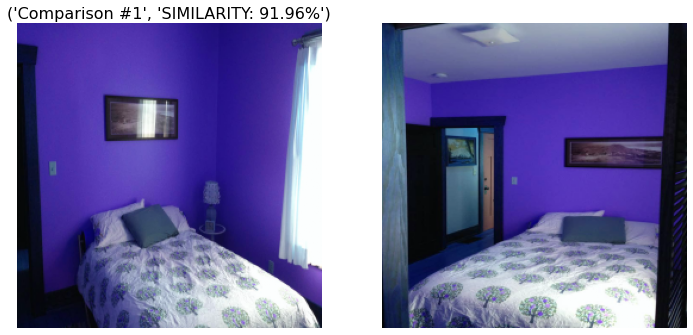

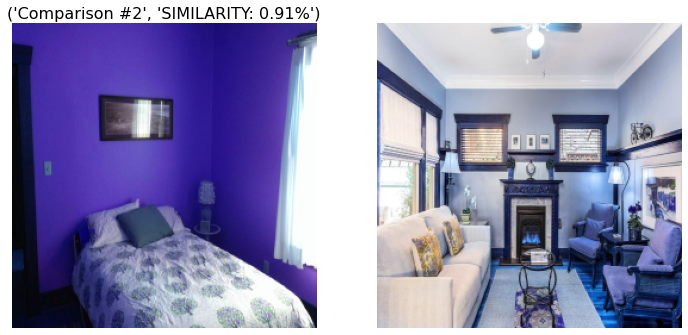

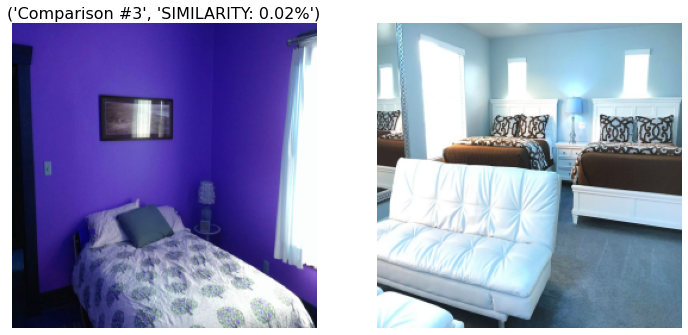

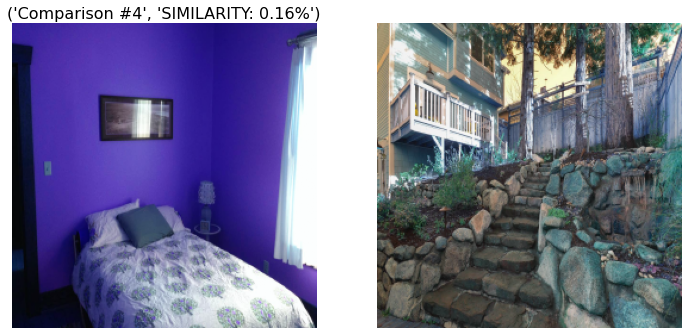

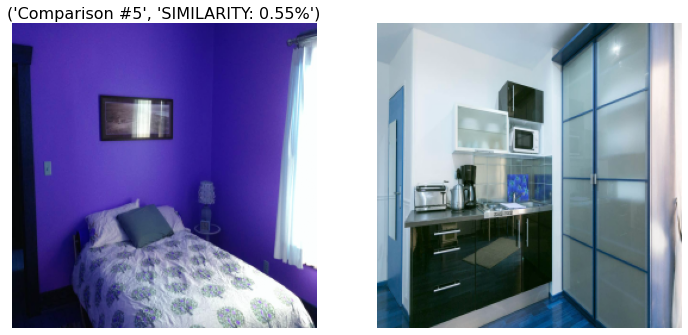

In [30]:
plot_example_one_shot(x_train, pairs, examples, n=5)

On Testing set...

In [39]:
pairs, examples = one_shot_batch(x_test, y_test, Labels_test, batch_size=230, n=5)

In [40]:
examples[1]

[array([159., 159., 159., 159., 159.]), array([ 63., 187., 122.,   2., 171.])]

In [41]:
correct = one_shot_task(pairs, examples, 5)

In [42]:
pd.Series(correct).mean()

0.6173913043478261

We get it right 62% of the time. This is reasonable when considering that random guessing would get us 20% correct (1 out of 5 images is the right answer). In summary, it falls short for being considered a good model, but is quite decent considering we had only 2 pictures for most rooms. However, the 100% obtained in training is a clear sign of overfitting, so this should be addressed in order to overfit less.

NOTE: 1st picture should be regarded as the most similar, since it is the only one which belongs to the same label

Result: CORRECT PREDICTION!




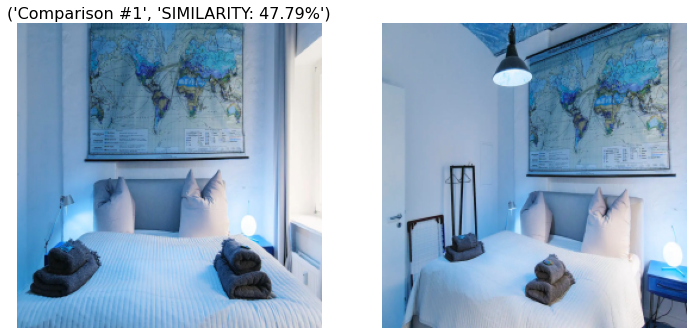

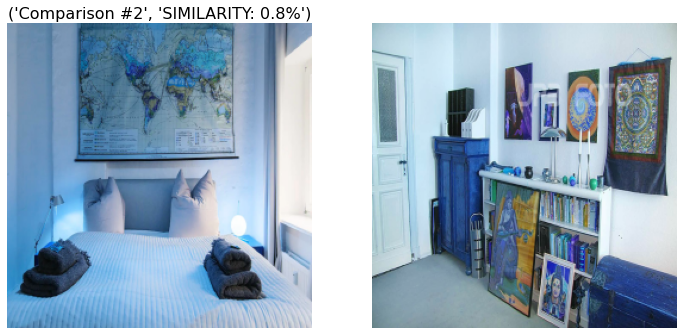

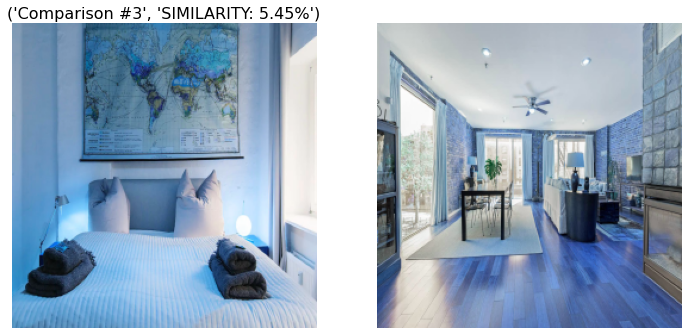

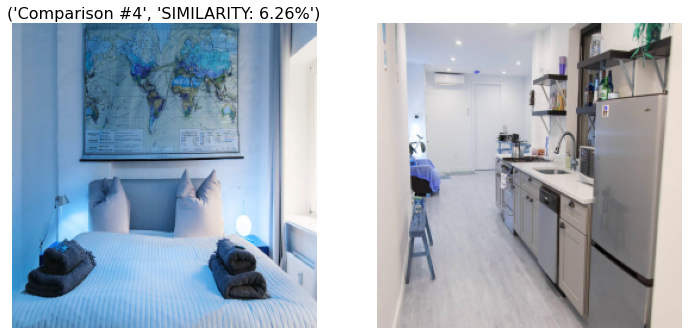

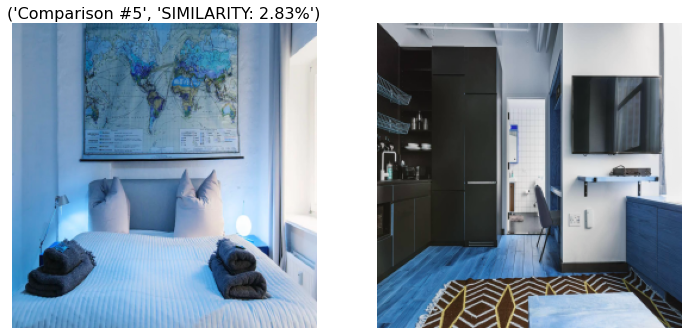

In [43]:
plot_example_one_shot(x_test, pairs, examples, n=5)